In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib

# Load Dataset
file_path = "final_dataset.csv"
data = pd.read_csv(file_path)   

   Unnamed: 0      Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTGS  ATGS  \
0           0  19/08/00  Charlton       Man City     4     0   H     0     0   
1           1  19/08/00   Chelsea       West Ham     4     2   H     0     0   
2           2  19/08/00  Coventry  Middlesbrough     1     3  NH     0     0   
3           3  19/08/00     Derby    Southampton     2     2  NH     0     0   
4           4  19/08/00     Leeds        Everton     2     0   H     0     0   

   HTGC  ...  HTLossStreak3  HTLossStreak5  ATWinStreak3 ATWinStreak5  \
0     0  ...              0              0             0            0   
1     0  ...              0              0             0            0   
2     0  ...              0              0             0            0   
3     0  ...              0              0             0            0   
4     0  ...              0              0             0            0   

  ATLossStreak3 ATLossStreak5 HTGD ATGD DiffPts DiffFormPts  
0             0   

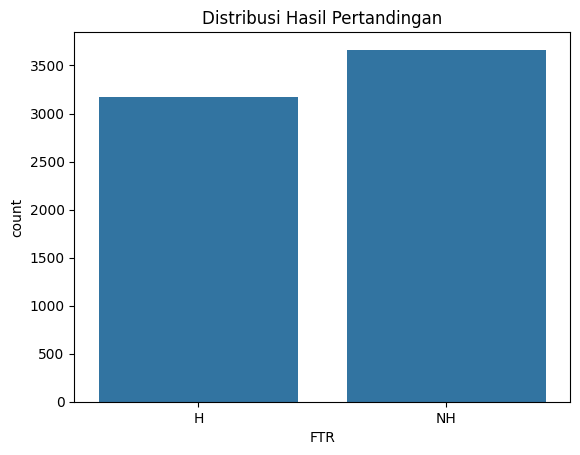

In [22]:
# Exploratory Data Analysis (EDA)
print(data.head())
print(data.info())
print(data.describe())

# Visualisasi Distribusi Hasil Pertandingan
sns.countplot(x=data['FTR'])
plt.title("Distribusi Hasil Pertandingan")
plt.show()


In [23]:
# Home Advantage
data['HomeAdvantage'] = data['HTGS'] - data['ATGS']

# Form: Klasifikasi performa 5 pertandingan terakhir (contoh saja)
# Nilai ini biasanya dari data historis, kita gunakan asumsi sederhana untuk demo
data['HomeForm'] = np.random.randint(0, 5, size=len(data))  # Dummy data
data['AwayForm'] = np.random.randint(0, 5, size=len(data))  # Dummy data

# Head-to-Head Record
data['H2H'] = np.random.randint(0, 3, size=len(data))  # Dummy data


In [24]:
# Encode Categorical Features with OneHotEncoder
cat_features = ['HomeTeam', 'AwayTeam']
encoder = OneHotEncoder(sparse_output=False)  # Perbaikan di sini
encoded_features = pd.DataFrame(encoder.fit_transform(data[cat_features]))
encoded_features.columns = encoder.get_feature_names_out(cat_features)

# Drop original categorical columns and merge encoded features
data = pd.concat([data.drop(cat_features, axis=1), encoded_features], axis=1)

# Encode Target Variable (FTR)
label_encoder = LabelEncoder()
data['FTR'] = label_encoder.fit_transform(data['FTR'])

In [25]:
# Pastikan kolom tanggal dikonversi ke tipe datetime
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%y', errors='coerce')

# Drop baris dengan nilai tanggal yang tidak valid
data = data.dropna(subset=['Date'])

In [26]:
# Pisahkan fitur dan label
X = data.drop(['FTR', 'Date'], axis=1)  # Pastikan kolom tanggal dan label tidak menjadi bagian dari fitur
y = data['FTR']

In [27]:
# Periksa tipe data setiap kolom
non_numeric_cols = X.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Kolom non-numerik ditemukan: {non_numeric_cols}")
    # Terapkan OneHotEncoder pada kolom non-numerik
    X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)


Kolom non-numerik ditemukan: Index(['HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5',
       'HTFormPtsStr', 'ATFormPtsStr'],
      dtype='object')


In [28]:
# Terapkan SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Resampling selesai!")

Resampling selesai!


In [29]:
# Train Multiple Models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}

In [30]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"Model: {name}")
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Model: RandomForest
Accuracy: 0.6016081871345029
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       634
           1       0.62      0.65      0.64       734

    accuracy                           0.60      1368
   macro avg       0.60      0.60      0.60      1368
weighted avg       0.60      0.60      0.60      1368

Model: GradientBoosting
Accuracy: 0.6388888888888888
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.53      0.57       634
           1       0.64      0.74      0.69       734

    accuracy                           0.64      1368
   macro avg       0.64      0.63      0.63      1368
weighted avg       0.64      0.64      0.63      1368



In [31]:
# Choose the best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

In [32]:
# Save the Best Model
joblib.dump(best_model, "best_model.pkl")

['best_model.pkl']

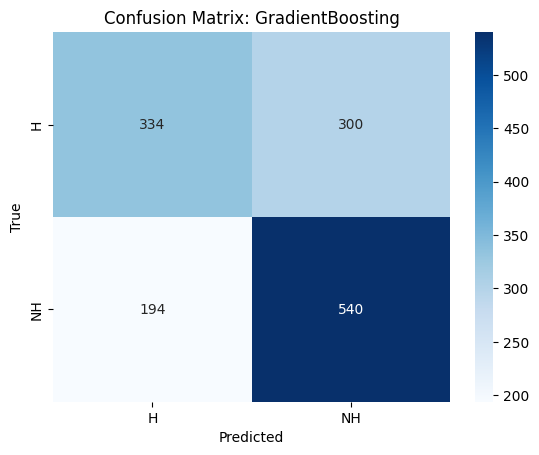

In [33]:
# Visualisasi Confusion Matrix untuk model terbaik
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Confusion Matrix: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()